In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from pyspark.sql import SparkSession
from pyspark.sql import dataframe
from pyspark.sql.types import StructType, StructField, DoubleType
import time
import glob
import json

from matplotlib import rc

rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = []
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'light'

activations = ['relu', 'softplus', 'leaky_relu', 'elu']

2022-11-18 04:15:18.735612: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-18 04:15:20.588804: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /software/gcc/8.2/lib64:/software/openmpi-intel/3.1.6/lib:/opt/intel/2019/compilers_and_libraries/linux/compiler/lib/intel64_lin/:/beegfs/desy/user/apaul/HEPfit/BAT_parallel/lib:/home/apaul/opt/local/lib/root:/home/apaul/opt/local/lib:/home/apaul/opt/local/lib64:
2022-11-18 04:15:20.588853: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on yo

In [2]:
def testModel(path: str, df_i: pd.DataFrame):
    df = df_i.copy(deep=True)
    if any(x in path for x in ['dnn', 'skip']):
        # load the model
        regressor = tf.keras.models.load_model(glob.glob(path+'dnn-*.tfm.hdf5')[0])
        # load the best weights
        regressor.load_weights(glob.glob(path+'checkpoint-*.hdf5')[0])
        #load the config file
        with open(glob.glob(path+'config*.json')[0]) as f:
            config = json.load(f)
    
    input_shape = config['input_shape']
    if config['scaled'] == 'normal':
        df['y_pred'] = regressor.predict(df[['x'+str(i+1) for i in range(input_shape)]]) * config['sigma'] + config['mu']
    else:
        df['y_pred'] = regressor.predict(df[['x'+str(i+1) for i in range(input_shape)]])
        
    df['relative_error'] = (1 - df['y_pred']/df['yN'])
    df['relative_percentage_error'] = df['relative_error'] * 100
    
    return config, df

In [3]:
# Spark session and configuration
spark = (SparkSession.builder.master("local[48]")
         .config('spark.executor.instances', 16)
         .config('spark.executor.cores', 16)
         .config('spark.executor.memory', '10g')
         .config('spark.driver.memory', '15g')
         .config('spark.memory.offHeap.enabled', True)
         .config('spark.memory.offHeap.size', '20g')
         .config('spark.dirver.maxResultSize', '20g')
         .config('spark.debug.maxToStringFields', 100)
         .appName("amp.hell").getOrCreate())

# Enable Arrow-based columnar data 
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
spark.conf.set(
    "spark.sql.execution.arrow.pyspark.fallback.enabled", "true"
)

# read the data into a spark frame
start = time.time()
path = '../data/'
header = ['x'+str(i+1) for i in range(8)] + ['yN', 'y_2'] 
schema = StructType([StructField(header[i], DoubleType(), True) for i in range(10)])
df = spark.read.options(delimiter=',').schema(schema).format("csv").load(path+str(8)+'D'+'/test/*.csv.*', header='true')

print('INFO: data loaded into Spark session in {:.3f} seconds'.format(time.time() - start))

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/11/18 04:16:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/11/18 04:16:12 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/11/18 04:16:12 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
22/11/18 04:16:12 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
22/11/18 04:16:12 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.


INFO: data loaded into Spark session in 4.105 seconds


In [4]:
# transfer the data to a pandas dataframe
start = time.time()
df_p = df.limit(1000000).toPandas() 
print('INFO: data loaded into pandas dataframe in {:.3f} seconds'.format(time.time() - start))

INFO: data loaded into pandas dataframe in 9.108 seconds


In [5]:
config_relu, df_relu = testModel('../src/dnn/activations/skip-tf-8D-yN-de63a534-normal-9-50-relu-512-adam-exp-schedule-mse-val_mse-84.159706-99.966286/', df_p)
config_elu, df_elu = testModel('../src/dnn/activations/skip-tf-8D-yN-9a7d4987-normal-9-50-elu-512-adam-exp-schedule-mse-val_mse-57.544025-99.669405/', df_p)
config_leaky_relu, df_leaky_relu = testModel('../src/dnn/activations/skip-tf-8D-yN-c950b6c9-normal-9-50-leaky_relu-512-adam-exp-schedule-mse-val_mse-93.360493-99.984633/', df_p)
config_softplus, df_softplus = testModel('../src/dnn/activations/skip-tf-8D-yN-9e11027b-normal-9-50-softplus-512-adam-exp-schedule-mse-val_mse-60.018051-99.813636/', df_p)
config_swish, df_swish = testModel('../src/dnn/activations/skip-tf-8D-yN-0a9e7cf7-normal-9-50-swish-512-adam-exp-schedule-mse-val_mse-51.167661-99.604730/', df_p)

2022-11-18 04:16:29.502030: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /software/gcc/8.2/lib64:/software/openmpi-intel/3.1.6/lib:/opt/intel/2019/compilers_and_libraries/linux/compiler/lib/intel64_lin/:/beegfs/desy/user/apaul/HEPfit/BAT_parallel/lib:/home/apaul/opt/local/lib/root:/home/apaul/opt/local/lib:/home/apaul/opt/local/lib64:
2022-11-18 04:16:29.502301: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-18 04:16:29.502338: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (max-wne001.desy.de): /proc/driver/nvidia/version does not exist
2022-11-18 04:16:29.502938: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

31250/31250 [==============================] - 27s 839us/step


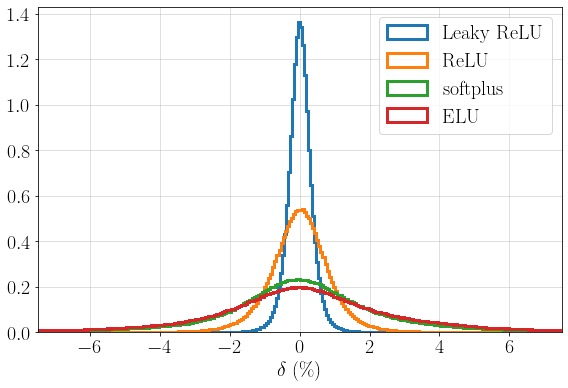

In [13]:
plt.figure(figsize=(8,5.5))
lim = 7.5
bins = 250
linewidth = 3
plt.hist(df_leaky_relu[abs(df_leaky_relu['relative_percentage_error']) < lim]['relative_percentage_error'], bins=bins, histtype='step', linewidth=linewidth, density=True, label='Leaky ReLU')
plt.hist(df_relu[abs(df_relu['relative_percentage_error']) < lim]['relative_percentage_error'], bins=bins, histtype='step', linewidth=linewidth, density=True, label='ReLU')
plt.hist(df_softplus[abs(df_softplus['relative_percentage_error']) < lim]['relative_percentage_error'], bins=bins, histtype='step', linewidth=linewidth, density=True, label='softplus')
plt.hist(df_elu[abs(df_elu['relative_percentage_error']) < lim]['relative_percentage_error'], bins=bins, histtype='step', linewidth=linewidth, density=True, label='ELU')
# plt.hist(df_swish[abs(df_swish['relative_percentage_error']) < lim]['relative_percentage_error'], bins=bins, histtype='step', linewidth=linewidth, density=True, label='swish')

plt.xlabel(r'$\delta$ (\%)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim((-lim, lim))
plt.grid(':', alpha=0.5)
plt.legend(fontsize=20)

plt.tight_layout()
plt.savefig('../plots/activations.pdf', dpi=300)
plt.show()